<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Diffusion-equation" data-toc-modified-id="Diffusion-equation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Diffusion equation</a></span></li><li><span><a href="#implementations" data-toc-modified-id="implementations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>implementations</a></span><ul class="toc-item"><li><span><a href="#Python:-explicit-[]" data-toc-modified-id="Python:-explicit-[]-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Python: explicit <code>[]</code></a></span></li><li><span><a href="#Numpy" data-toc-modified-id="Numpy-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Numpy</a></span></li><li><span><a href="#Numba" data-toc-modified-id="Numba-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Numba</a></span></li><li><span><a href="#Cython:-exact-python" data-toc-modified-id="Cython:-exact-python-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Cython: exact python</a></span></li><li><span><a href="#Cython:-with-type-annotation" data-toc-modified-id="Cython:-with-type-annotation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Cython: with type annotation</a></span></li><li><span><a href="#Cython:-optimized-for-strides" data-toc-modified-id="Cython:-optimized-for-strides-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Cython: optimized for strides</a></span></li><li><span><a href="#Cython:-C" data-toc-modified-id="Cython:-C-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Cython: C</a></span></li><li><span><a href="#C/C++" data-toc-modified-id="C/C++-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>C/C++</a></span><ul class="toc-item"><li><span><a href="#Compile-and-run" data-toc-modified-id="Compile-and-run-2.8.1"><span class="toc-item-num">2.8.1&nbsp;&nbsp;</span>Compile and run</a></span></li></ul></li><li><span><a href="#Test-the-correctness" data-toc-modified-id="Test-the-correctness-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Test the correctness</a></span></li></ul></li><li><span><a href="#Have-a-break:-Visualization-of-the-temperature" data-toc-modified-id="Have-a-break:-Visualization-of-the-temperature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Have a break: Visualization of the temperature</a></span></li><li><span><a href="#Test-speed" data-toc-modified-id="Test-speed-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test speed</a></span><ul class="toc-item"><li><span><a href="#Discussion" data-toc-modified-id="Discussion-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li></ul></div>

# Diffusion equation

Stationary diffusion equation
$$\frac{\partial^2 \phi}{\partial^2 x} + \frac{\partial^2 \phi}{\partial^2 y} = -\rho$$
where the $\rho$ is the source, $\phi$ is the density.

In the heat transfer example, the heat source is the source, and the temperature is the "heat density".

We can descrese the equation as
$$
\frac{\phi(x+\Delta x,y) + \phi(x-\Delta x,y) + \phi(x,y+\Delta x) + \phi(x,y-\Delta x) - 4\phi(x,y)}{(\Delta x) ^2} =  -\rho
$$
where $\Delta x = \Delta y$
Then we can write down the iteration equation
$$
\phi(x,y) = \frac{\phi(x+\Delta x,y) + \phi(x-\Delta x,y) + \phi(x,y+\Delta x) + \phi(x,y-\Delta x)}{4} + (\Delta x) ^2 \rho
$$

# implementations

In [1]:
import sys
print(sys.version)

3.6.7 |Anaconda, Inc.| (default, Dec 10 2018, 20:35:02) [MSC v.1915 64 bit (AMD64)]


In [2]:
def test_speed(solver, n_updates=1000):
    
    print("benchmarking: %s"%solver.__name__)
    ns = 10 ** np.linspace(1.5, 3, 10)
    ans=[]
    
    for n_float in ns:
        
        n = int(n_float)
        rho = np.zeros((n, n), dtype=np.float64)
        phi = np.zeros((n, n), dtype=np.float64)
        t=%timeit -r3 -o solver(phi, rho, 1, 0.1, n_updates)
        ans.append(t)
        
        time = t.average
        print("Average time of %10.4f s for %4d updates on grid of %dx%d"%(float(time), n_updates, int(n), int(n)))
    
    return ans

## Python: explicit `[]`

In [3]:
#%%writefile temp.py
import numpy as np


def temperature_python(phi, rho, alpha, dx, n_iter):
    # phi[0,:] the left boundary, not update
    # phi[phi.shape[0]-1,:] the right boundary, not update
    # phi[0,:] the left boundary, not update
    # phi[:,phi.shape[1]-1] the top boundary, not update

    # a buffer is needed
    # we don't want to refer the updated result
    # when we write e.g. phi[i-1,j]
    phi_update = np.empty_like(phi)
    for it in range(n_iter):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi_update[i, j] = 0.25 * (phi[i - 1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = phi_update[i, j]

In [4]:
t_python=test_speed(temperature_python, n_updates=1)

benchmarking: temperature_python
1.63 ms ± 10.8 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
Average time of     0.0016 s for    1 updates on grid of 31x31
3.87 ms ± 91.6 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0039 s for    1 updates on grid of 46x46
9.3 ms ± 285 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0093 s for    1 updates on grid of 68x68
19.1 ms ± 218 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0191 s for    1 updates on grid of 100x100
41.6 ms ± 208 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0416 s for    1 updates on grid of 146x146
88.9 ms ± 289 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0889 s for    1 updates on grid of 215x215
199 ms ± 653 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.1986 s for    1 updates on grid of 316x316
425 ms ± 4.14 ms per lo

## Numpy

In [5]:
def temperature_numpy(phi, rho, alpha, dx, n_iter):

    M = phi.shape[0]
    N = phi.shape[1]
    rho = dx**2 * rho[1:M - 1, 1:N - 1]
    for _ in range(n_iter):
        phi[1:M - 1, 1:N - 1] = 0.25*(phi[0:M - 2, 1:N - 1]\
            + phi[2:M, 1:N - 1]\
            + phi[1:M-1, 0:N - 2]\
            + phi[1:M-1, 2:N])\
            + rho

In [6]:
t_numpy=test_speed(temperature_numpy)

benchmarking: temperature_numpy
12.4 ms ± 173 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0124 s for 1000 updates on grid of 31x31
16.2 ms ± 121 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0162 s for 1000 updates on grid of 46x46
29 ms ± 1.05 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0290 s for 1000 updates on grid of 68x68
50.2 ms ± 1.58 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0502 s for 1000 updates on grid of 100x100
90.1 ms ± 1.07 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0901 s for 1000 updates on grid of 146x146
173 ms ± 3.67 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.1725 s for 1000 updates on grid of 215x215
750 ms ± 22.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Average time of     0.7500 s for 1000 updates on grid of 316x316
2.91 s ± 35.3 ms per loop (m

## Numba

In [7]:
import numba as nb
#parallel=True not work in this case
temperature_numba = nb.jit(nopython=True)(temperature_python)
temperature_numba_numpy = nb.jit(nopython=True)(temperature_numpy)

In [8]:
t_numba=test_speed(temperature_numba)
t_numba_numpy=test_speed(temperature_numba_numpy)

benchmarking: temperature_python
990 µs ± 37.5 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Average time of     0.0010 s for 1000 updates on grid of 31x31
2.12 ms ± 70.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0021 s for 1000 updates on grid of 46x46
3.65 ms ± 80.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0037 s for 1000 updates on grid of 68x68
8.05 ms ± 299 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0081 s for 1000 updates on grid of 100x100
19.1 ms ± 342 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0191 s for 1000 updates on grid of 146x146
40.4 ms ± 639 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0404 s for 1000 updates on grid of 215x215
88.8 ms ± 1.46 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0888 s for 1000 updates on grid of 316x316
251 ms ± 8.15 ms per lo

## Cython: exact python

In [9]:
# please install cython
# >>> conda install cython
%load_ext cython

We compile the python to C code. The only optimization is avoiding the reading the bytecode and parsing. Because, in this mode, we still use CPython runtime and the CPython runtime is the slowest part. We except there is no acceleration.

In [10]:
%%cython
#%load temp.py
import numpy as np

def temperature_cython_python(phi, rho, alpha, dx, n_iter):
    # phi[0,:] the left boundary, not update
    # phi[phi.shape[0]-1,:] the right boundary, not update
    # phi[0,:] the left boundary, not update
    # phi[:,phi.shape[1]-1] the top boundary, not update
    
    # a buffer is needed
    # we don't want to refer the updated result
    # when we write e.g. phi[i-1,j]
    phi_update = np.empty_like(phi)
    for it in range(n_iter):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi_update[i, j] = 0.25 * (phi[i - 1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = phi_update[i, j]

In [11]:
t_cython_python=test_speed(temperature_cython_python,n_updates=1)

benchmarking: temperature_cython_python
1.43 ms ± 13.9 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
Average time of     0.0014 s for    1 updates on grid of 31x31
3.12 ms ± 20.6 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0031 s for    1 updates on grid of 46x46
7.29 ms ± 26.2 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0073 s for    1 updates on grid of 68x68
16.1 ms ± 88.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0161 s for    1 updates on grid of 100x100
34.7 ms ± 277 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0347 s for    1 updates on grid of 146x146
74.7 ms ± 144 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0747 s for    1 updates on grid of 215x215
166 ms ± 1.86 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.1662 s for    1 updates on grid of 316x316
360 ms ± 731

## Cython: with type annotation

Cypton is new to me. I hope writing this simple example doesn't require a Cython expert. However, it seems not the case. I looked into the generated c code (via `cython -a`). The generated code doesn't assume the strides to be 1. The code even uses a function to calculate the address from indices. I don't how much the calculation will effect.

In [12]:
%%cython
import numpy as np
cimport numpy as np
cimport cython


@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_typed(np.ndarray[np.float64_t, ndim=2, mode="c"] phi,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update = np.empty_like(phi)
    cdef int M = phi.shape[0]
    cdef int N = phi.shape[1]
    cdef int i = 0
    cdef int j = 0
            
    for it in range(n_iter):
        for i in range(1, M-1):
            for j in range(1, N-1):
                phi_update[i, j] = 0.25 * (phi[i - 1, j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, M-1):
            for j in range(1, N-1):     
                phi[i,j] = phi_update[i,j]
                

In [13]:
t_cython_typed=test_speed(temperature_cython_typed)

benchmarking: temperature_cython_typed
3.2 ms ± 45.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0032 s for 1000 updates on grid of 31x31
6.33 ms ± 6.82 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0063 s for 1000 updates on grid of 46x46
12.5 ms ± 86.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0125 s for 1000 updates on grid of 68x68
25 ms ± 240 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0250 s for 1000 updates on grid of 100x100
50.4 ms ± 247 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0504 s for 1000 updates on grid of 146x146
104 ms ± 340 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.1042 s for 1000 updates on grid of 215x215
223 ms ± 1.58 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Average time of     0.2231 s for 1000 updates on grid of 316x316
522 ms ± 8.58 ms per l

## Cython: optimized for strides

Now, I tell the cython, the array is indeed a continuous `c` array. The function call for the calculation of index is avoid now.

In [14]:
%%cython
import numpy as np
cimport numpy as np
cimport cython


@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_optimized(np.ndarray[np.float64_t, ndim=2, mode="c"] phi_,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho_,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update_ = np.empty_like(phi_)    
    cdef int M = phi_.shape[0]
    cdef int N = phi_.shape[1]
    cdef int i = 0
    cdef int j = 0
    
    #####################
    # we assume it is continious c array
    #####################
    
    cdef double[:,::1] phi = phi_
    cdef double[:,::1] rho = rho_
    cdef double[:,::1] phi_update = phi_update_
            
    for it in range(n_iter):
        for i in range(1, M-1):
            for j in range(1, N-1):
                phi_update[i, j] = 0.25 * (phi[i - 1, j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, M-1):
            for j in range(1, N-1):     
                phi[i,j] = phi_update[i,j]
                

In [15]:
t_cython_optimized=test_speed(temperature_cython_optimized)

benchmarking: temperature_cython_optimized
2.45 ms ± 39.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0025 s for 1000 updates on grid of 31x31
4.68 ms ± 72.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0047 s for 1000 updates on grid of 46x46
9.11 ms ± 15.8 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0091 s for 1000 updates on grid of 68x68
18.1 ms ± 65.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0181 s for 1000 updates on grid of 100x100
35.6 ms ± 97.3 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0356 s for 1000 updates on grid of 146x146
72.9 ms ± 94 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0729 s for 1000 updates on grid of 215x215
152 ms ± 416 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.1521 s for 1000 updates on grid of 316x316
353 ms ± 18

## Cython: C

In [16]:
%%writefile temperature_c.c

#define INDEX(i,j) ((i)*N + (j))

void temperature_c(double * phi, double *phi_update, double * rho,
    int M, int N, double alpha, double dx, int n_iter) {

    // We will not reuse INDEX(i, j)
    // test the compiler!

    for (int it = 0; it < n_iter; ++it) {
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi_update[INDEX(i, j)] = 0.25*(phi[INDEX(i, j - 1)] + phi[INDEX(i, j + 1)]
                    + phi[INDEX(i - 1, j)] + phi[INDEX(i + 1, j)]) + dx * dx*rho[INDEX(i, j)];
            }
        }
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi[INDEX(i, j)] = phi_update[INDEX(i, j)];
            }
        }
    }
}


Overwriting temperature_c.c


Copy file to the directory that contains `*.pyx`. So the compiler can find our C code.

In [17]:
import os.path, shutil
from sys import platform

if platform == "linux" or platform == "linux2":
    # linux
    pyx_dir=os.path.join(os.path.expanduser('~'), ".cache/ipython/cython/")
    shutil.copy("temperature_c.c", pyx_dir)
elif platform == "darwin":
    # OS X
    # I don't have mac ...
    # Try fix this by yourself
    pass
elif platform == "win32":
    # Windows...
    pyx_dir=os.path.join(os.path.expanduser('~'), ".ipython\cython")
    shutil.copy("temperature_c.c", pyx_dir)

In the '.pyx' part, we transform `ndarray` to C pointer, then call the temperature_c.

In [18]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

cdef extern from "temperature_c.c":
    # C is include here so that it doesn't need to be compiled externally
    pass

cdef extern void temperature_c(double *,double *,double *rho, int, int, double, double, int)

@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_c(np.ndarray[np.float64_t, ndim=2, mode="c"] phi_,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho_,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update_ = np.empty_like(phi_)    
    cdef int M = phi_.shape[0]
    cdef int N = phi_.shape[1]
    cdef int i = 0
    cdef int j = 0
    
    #####################
    # we assume it is continious c array
    #####################
    
    cdef double[:,::1] phi = phi_
    cdef double[:,::1] rho = rho_
    cdef double[:,::1] phi_update = phi_update_
    
    temperature_c(&(phi[0,0]), &(phi_update[0,0]), &(rho[0,0]), M, N, alpha, dx, n_iter)
            

In [19]:
t_cython_c=test_speed(temperature_cython_c)

benchmarking: temperature_cython_c
1.15 ms ± 2.89 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
Average time of     0.0012 s for 1000 updates on grid of 31x31
2.64 ms ± 36.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0026 s for 1000 updates on grid of 46x46
6.04 ms ± 24.2 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0060 s for 1000 updates on grid of 68x68
13.3 ms ± 57.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Average time of     0.0133 s for 1000 updates on grid of 100x100
29.7 ms ± 353 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0297 s for 1000 updates on grid of 146x146
62.6 ms ± 211 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.0626 s for 1000 updates on grid of 215x215
137 ms ± 265 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Average time of     0.1371 s for 1000 updates on grid of 316x316
360 ms ± 13.2 ms p

## C/C++

It's not convient to use numpy in python's C++ extension. I wrote a standalone C++ program. 

- I don't do any manually optimization
- However, I will enable all possible optimization with my machine and compiler.

In [20]:
%%writefile temp.cxx

#include <stdio.h>
#include <vector>
#include <chrono>
#include <iostream>


#define INDEX(i,j) ((i)*N + (j))

void temperature_cpp(double *  phi, double const * rho,
    int M, int N, double alpha, double dx, int n_iter) {

    std::vector<double> phi_update_(M*N);
    double *phi_update = phi_update_.data();


    // We will not reuse INDEX(i, j)
    // test the compiler!

    for (int it = 0; it < n_iter; ++it) {
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi_update[INDEX(i, j)] = 0.25*(phi[INDEX(i, j - 1)] + phi[INDEX(i, j + 1)]
                    + phi[INDEX(i - 1, j)] + phi[INDEX(i + 1, j)]) + dx * dx*rho[INDEX(i, j)];
            }
        }
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi[INDEX(i, j)] = phi_update[INDEX(i, j)];
            }
        }
    }
}

int main()
{

    for (int d = 0; d < 10; ++d) {
        int M = (int)pow(10, 1.5 + (3.0 - 1.5)*d / 9);

        int N = M;
        std::vector<double> phi(M*N);
        std::vector<double> rho(M*N);

        for (int i = 0; i < M; ++i) {
            for (int j = 0; j < N; ++j) {
                double x = (i - M / 2) * 0.1;
                double y = (j - N / 2) * 0.1;
                rho[INDEX(i, j)] = x * x + y * y;
            }
        }

        int repeat = 200;
        int loops = repeat * 100 * 100 / (N + 1) / (M + 1) + 1;
        auto t0 = std::chrono::high_resolution_clock::now();
        for (int i = 0; i < loops; ++i) {
            temperature_cpp(phi.data(), rho.data(), M, N, 1., 0.1, 1000);
        }
        auto t1 = std::chrono::high_resolution_clock::now();
        auto period = std::chrono::duration_cast<std::chrono::microseconds>(t1 - t0);
        std::cout << loops << " " << M << " " << period.count() / (1000.0 * 1000.0 * loops) << "\n";

    }
}


Overwriting temp.cxx


### Compile and run

Build and run

In [21]:
from sys import platform

if platform == "linux" or platform == "linux2":
    # linux
    !g++ temp.cxx -O3 -o temp.exe
    cpp_result = !./temp.exe
elif platform == "darwin":
    # OS X
    # I don't have mac ...
    # Try fix this by yourself
    pass
elif platform == "win32":
    # For windows and VS2017
    !"C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Auxiliary\Build\vcvarsall.bat" x86_amd64 \
    && cl /EHsc /Ox /arch:AVX2 /nologo temp.cxx
    cpp_result = !temp.exe


**********************************************************************
** Visual Studio 2017 Developer Command Prompt v15.7.5
** Copyright (c) 2017 Microsoft Corporation
**********************************************************************
[vcvarsall.bat] Environment initialized for: 'x86_x64'
temp.cxx


In [22]:
def print_cpp_result():
    
    ans=[]
    for r in cpp_result:
        loops,dim,time=r.split()
        print("Average time of %8.2f s for 1000 updates on grid of %dx%d"%(float(time), int(dim), int(dim)))
        class TimeResult:
            def __init__(self, time):
                self.average=float(time)
                
        ans.append(TimeResult(time))
    global t_cpp
    t_cpp=ans
    
        
print_cpp_result()

Average time of     0.00 s for 1000 updates on grid of 31x31
Average time of     0.00 s for 1000 updates on grid of 46x46
Average time of     0.01 s for 1000 updates on grid of 68x68
Average time of     0.01 s for 1000 updates on grid of 100x100
Average time of     0.03 s for 1000 updates on grid of 146x146
Average time of     0.06 s for 1000 updates on grid of 215x215
Average time of     0.14 s for 1000 updates on grid of 316x316
Average time of     0.35 s for 1000 updates on grid of 464x464
Average time of     0.94 s for 1000 updates on grid of 681x681
Average time of     2.54 s for 1000 updates on grid of 1000x1000


## Test the correctness

In [23]:
def test_they_are_same():
    
    nx = 50
    rho = np.zeros((nx, nx), dtype=np.float64)
    
    xx, yy = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
    rho[:, :] = np.abs(np.sqrt(xx**2 + yy**2) - 0.3) < 0.1

    
    n_iter=2
    # python
    phi_python = np.zeros((nx, nx), dtype=np.float64)
    temperature_numpy(phi_python, rho, 1, 0.1, n_iter)
    
    # numpy
    phi_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numpy(phi_numpy, rho, 1, 0.1, n_iter)

    assert np.allclose(phi_numpy, phi_numpy)
    
    # numba
    phi_numba = np.zeros((nx, nx), dtype=np.float64)
    temperature_numba(phi_numba, rho, 1, 0.1, n_iter)
        
    phi_numba_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numba_numpy(phi_numba_numpy, rho, 1, 0.1, n_iter)

    assert np.allclose(phi_numba, phi_numpy)
    assert np.allclose(phi_numba_numpy, phi_numpy)
    
    # cython
    phi_cython_python = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_python(phi_cython_python, rho, 1, 0.1, n_iter)

    phi_cython_typed = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_typed(phi_cython_typed, rho, 1, 0.1, n_iter)

    phi_cython_optimized = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_optimized(phi_cython_optimized, rho, 1, 0.1, n_iter)

    phi_cython_c = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_c(phi_cython_c, rho, 1, 0.1, n_iter)    
    
    assert np.allclose(phi_cython_python, phi_numpy)
    assert np.allclose(phi_cython_typed, phi_numpy)
    assert np.allclose(phi_cython_optimized, phi_numpy)
    assert np.allclose(phi_cython_c, phi_numpy)

test_they_are_same()

# Have a break: Visualization of the temperature

Now, see the results. ^_^ 

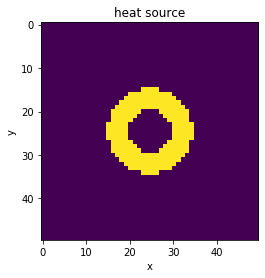

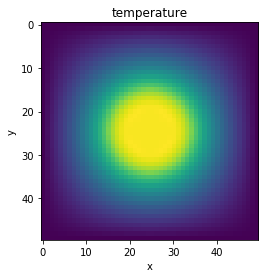

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot():
    
    nx = 50
    rho = np.zeros((nx, nx), dtype=np.float64)
    
    xx, yy = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
    rho[:, :] = np.abs(np.sqrt(xx**2 + yy**2) - 0.3) < 0.1

    plt.figure()
    plt.imshow(rho)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("heat source")
    plt.show()

    n_iter=1000
            
    phi_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numpy(phi_numpy, rho, 1, 0.1, n_iter)
    
    plt.figure()
    plt.imshow(phi_numpy)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("temperature")
    plt.show()
    
plot()

# Test speed

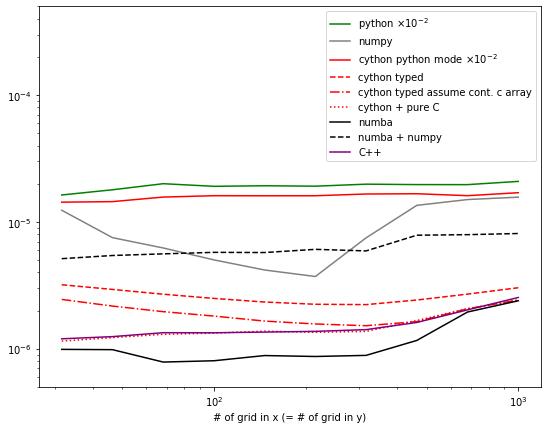

In [25]:
def plot_figure():
    
    ns = 10 ** np.linspace(1.5, 3, 10)
    ng = ns * ns
    
    a_python = [t.average for t in t_python]
    a_numpy = [t.average for t in t_numpy]
    
    a_numba = [t.average for t in t_numba]
    a_numba_numpy = [t.average for t in t_numba_numpy]
    
    a_cython_python = [t.average for t in t_cython_python]
    a_cython_typed = [t.average for t in t_cython_typed]
    a_cython_optimzed = [t.average for t in t_cython_optimized]
    a_cython_c = [t.average for t in t_cython_c]

    a_cpp = [t.average for t in t_cpp]
    
    plt.figure(figsize=(9,7))
    plt.yscale('log')
    plt.xscale('log')
    
    plt.plot(ns, a_python/ng * 10, label="python $\\times 10^{-2}$", color="green")
    
    plt.plot(ns, a_numpy/ng, label="numpy", color="gray")
    
    plt.plot(ns, a_cython_python/ng * 10, label="cython python mode $\\times 10^{-2}$", color="red")
    plt.plot(ns, a_cython_typed/ng, label="cython typed", color="red", linestyle='--')
    plt.plot(ns, a_cython_optimzed/ng, label="cython typed assume cont. c array", color="red", linestyle='-.')
    plt.plot(ns, a_cython_c/ng, label="cython + pure C", color="red", linestyle=':')
    
    plt.plot(ns, a_numba/ng, label="numba", color="black")
    plt.plot(ns, a_numba_numpy/ng, label="numba + numpy", color="black", linestyle="--")
    
    plt.plot(ns, a_cpp/ng, label="C++", color="purple")
    
    plt.xlabel("# of grid in x (= # of grid in y)")
    plt.ylim((5E-7,5E-4))
    plt.legend()
    plt.show()
    
plot_figure()

## Discussion

- Python就是单纯的慢。Python大多时间花费在了CPython的运行时上。而CPython运行时之所以慢是因为大多数时间用在了类型检查上。花费在单位格点上的时间和格点的数量无关，因为CPython运行时太慢了，运行总时间和cpu缓存等等基本没有关系。


- Cython的纯python模式的速度和CPython的python模式的速度相近。Cython主要是节省了读取bytecode，解析bytecode的时间。而这一部分时间很少。


- 如果自己写循环的话，`numpy`的性能是很不错，与`C/C++`语言或者在一个数量级。如果不自己写循环，`numba`对`numpy`没有加速。


- `cython` + pure `C`和`C/C++`几乎一样快。他们使用了同一个编译器（编译选项可能也一样），所以性能相同。


- `numba`对于所以格点数量都是最优秀的。`numba`的速度比没有做低阶优化的`C++`或者`C`还要快。但是随着格点数量增加，缓存速度成为速度瓶颈，无论是`cython`,  `C/C++`还是`numba`速度都趋于相同。
